In [67]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  5 13:03:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    34W / 250W |    451MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [68]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


• DOMAIN: Digital content management

• CONTEXT: Classification is probably the most popular task that you would deal with in real life. Text in the form of blogs, posts, articles, etc. is written every second. It is a challenge to predict the information about the writer without knowing about him/her. We are going to create a classifier that predicts multiple features of the author of a given text. We have designed it as a Multi label classification problem.

• DATA DESCRIPTION: Over 600,000 posts from more than 19 thousand bloggers The Blog Authorship Corpus consists of the collected posts of 19,320 bloggers gathered from blogger.com in August 2004. The corpus incorporates a total of 681,288 posts and over 140 million words - or approximately 35 posts and 7250 words per person. Each blog is presented as a separate file, the name of which indicates a blogger id# and the blogger’s self-provided gender, age, industry, and astrological sign. (All are labelled for gender and age but for many, industry and/or sign is marked as unknown.) All bloggers included in the corpus fall into one of three age groups:

• 8240 "10s" blogs (ages 13-17),
• 8086 "20s" blogs(ages 23-27) and • 2994 "30s" blogs (ages 33-47)

For each age group, there is an equal number of male and female bloggers.
Each blog in the corpus includes at least 200 occurrences of common English words. All formatting has been stripped with two exceptions. Individual posts within a single blogger are separated by the date of the following post and links within a post are denoted by the label url link. Link to dataset: https://www.kaggle.com/rtatman/blog-authorship-corpus

• PROJECT OBJECTIVE: The need is to build a NLP classifier which can use input text parameters to determine the label/s of the blog. Steps and tasks:

1. Import and analyse the data set.
2. Perform data pre-processing on the data:

  • Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.

  • Target/label merger and transformation
  • Train and test split
  • Vectorisation, etc.

3. Design, train, tune and test the best text classifier.
4. Display and explain detail the classification report
5. Print the true vs predicted labels for any 5 entries from the dataset.
Hint: The aim here Is to import the text, process it such a way that it can be taken as an inout to the ML/NN classifiers. Be analytical and experimental here in trying new approaches to design the best model.

In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # regular expression
import nltk
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 16)})
sns.set_theme(style="darkgrid") #// for version 11 :/

In [70]:
#data=pd.read_csv("/content/drive/MyDrive/AIML/NLP/blogtext.csv", nrows=100000)
data=pd.read_csv("/content/drive/MyDrive/AIML/NLP/blogtext.csv")

In [71]:
data.head(10)

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",I had an interesting conversation...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Somehow Coca-Cola has a way of su...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004","If anything, Korea is a country o..."
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Take a read of this news article ...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",I surf the English news sites a l...


In [72]:
data.isna().any()

id        False
gender    False
age       False
topic     False
sign      False
date      False
text      False
dtype: bool

In [73]:
data.shape

(681284, 7)

In [74]:
data=data.head(10000)

In [75]:
data.describe(include = [np.number]).T

,count,mean,std,min,25%,50%,75%,max
id,10000.0,1.854823e+06,1.303245e+06,467705.0,649790.0,1103575.0,3176655.0,4321554.0
age,10000.0,2.801930e+01,8.123923e+00,13.0,23.0,27.0,35.0,46.0


In [76]:
print(data.age.value_counts())

35    2315
36    1708
17    1185
27    1054
24     655
15     602
34     553
16     440
25     386
23     253
26     234
14     212
33     136
39      79
38      46
13      42
37      33
41      20
45      16
42      14
46       7
43       6
44       3
40       1
Name: age, dtype: int64


In [77]:
data.describe(include = [np.object]).T

,count,unique,top,freq
gender,10000,2,male,5916
topic,10000,26,indUnk,3287
sign,10000,12,Aries,4198
date,10000,718,"05,August,2004",2329
text,10000,9949,,13


In [78]:
orignal_mem = data.memory_usage(deep=True)

In [79]:
orignal_mem

Index          128
id           80000
gender      618168
age          80000
topic       650297
sign        632415
date        704036
text      10799209
dtype: int64

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  int64 
 1   gender  10000 non-null  object
 2   age     10000 non-null  int64 
 3   topic   10000 non-null  object
 4   sign    10000 non-null  object
 5   date    10000 non-null  object
 6   text    10000 non-null  object
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [81]:
data.drop(['id','date'], axis=1, inplace=True)

In [82]:
data.head()

,gender,age,topic,sign,text
0,male,15,Student,Leo,"Info has been found (+/- 100 pages,..."
1,male,15,Student,Leo,These are the team members: Drewe...
2,male,15,Student,Leo,In het kader van kernfusie op aarde...
3,male,15,Student,Leo,testing!!! testing!!!
4,male,33,InvestmentBanking,Aquarius,Thanks to Yahoo!'s Toolbar I can ...


In [83]:
data['age']=data['age'].astype('object')

In [84]:
data.gender.value_counts()

male      5916
female    4084
Name: gender, dtype: int64

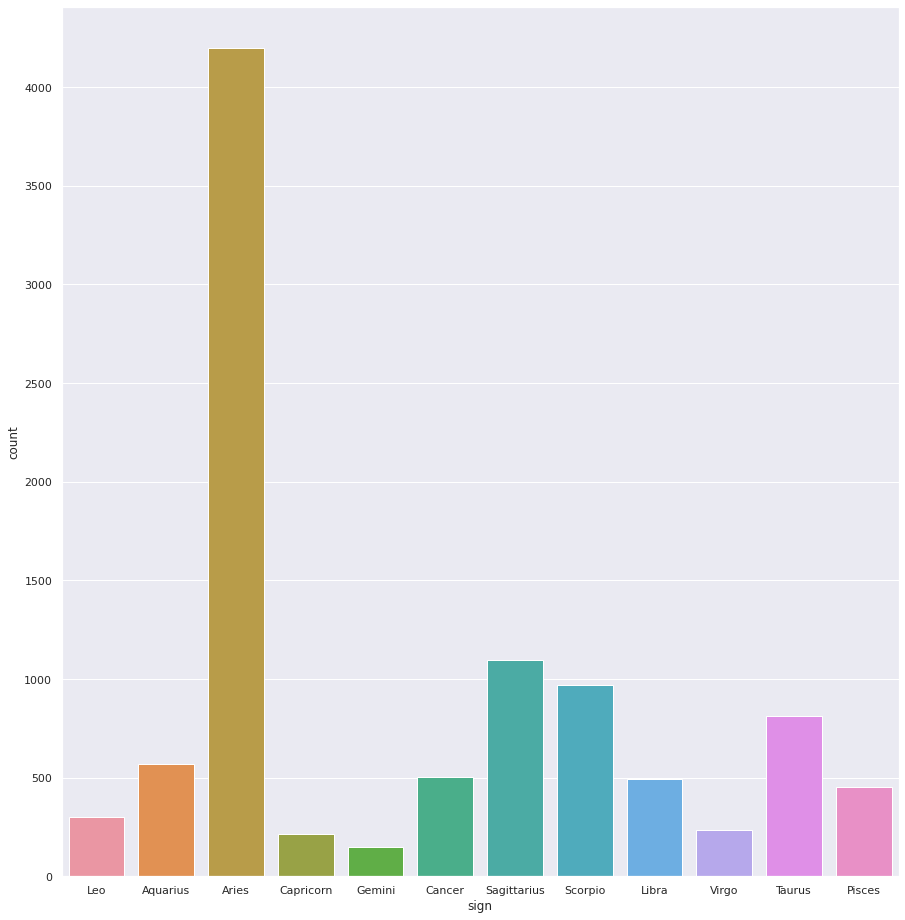

In [85]:
sns.countplot(x='sign',data=data)

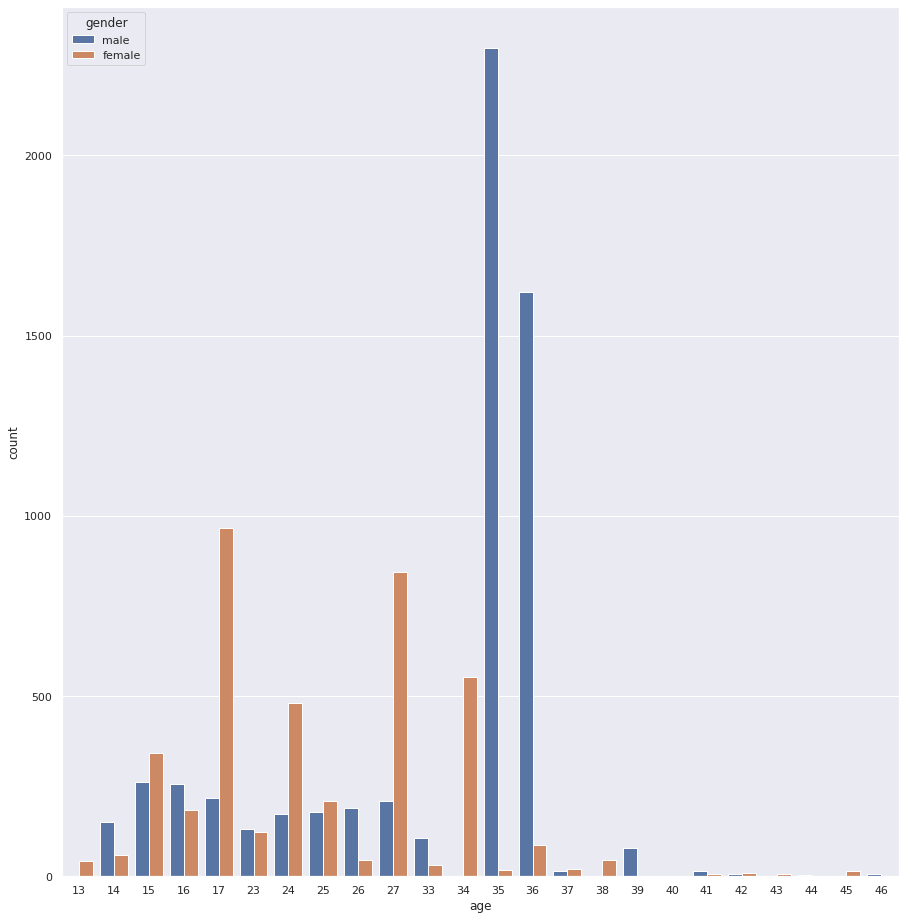

In [86]:
sns.countplot(x="age", hue="gender", data=data)

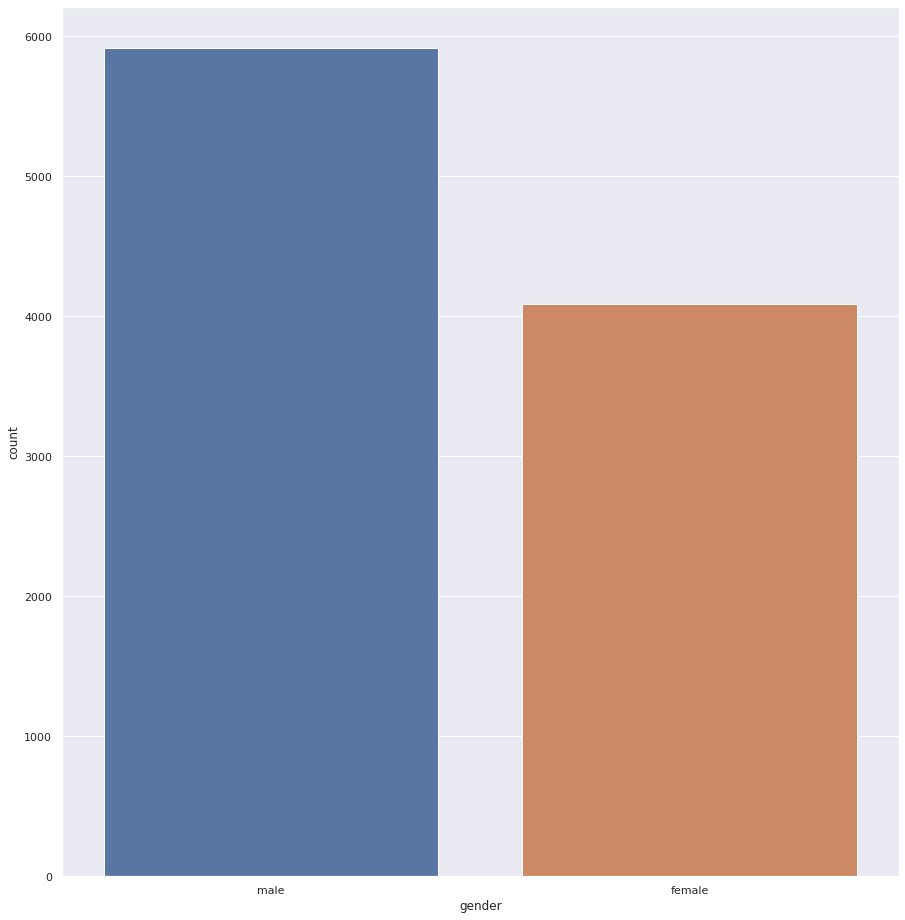

In [87]:
sns.countplot(x='gender',data=data)

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  10000 non-null  object
 1   age     10000 non-null  object
 2   topic   10000 non-null  object
 3   sign    10000 non-null  object
 4   text    10000 non-null  object
dtypes: object(5)
memory usage: 390.8+ KB


In [89]:
data['clean_data']=data['text'].apply(lambda x: re.sub(r'[^A-Za-z]+',' ',x))

In [90]:
data['clean_data']=data['clean_data'].apply(lambda x: x.lower())

In [91]:
data['clean_data']=data['clean_data'].apply(lambda x: x.strip())

In [92]:
print("Actual data=======> {}".format(data['text'][1]))

Actual data=======>            These are the team members:   Drewes van der Laag           urlLink mail  Ruiyu Xie                     urlLink mail  Bryan Aaldering (me)          urlLink mail          


In [93]:
print("Cleaned data=======> {}".format(data['clean_data'][1]))

Cleaned data=======> these are the team members drewes van der laag urllink mail ruiyu xie urllink mail bryan aaldering me urllink mail


In [94]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
data['clean_data']=data['clean_data'].apply(lambda x: ' '.join([words for words in x.split() if words not in stopwords]))

In [96]:
data['clean_data'][6]

'somehow coca cola way summing things well early flagship jingle like buy world coke tune like teach world sing pretty much summed post woodstock era well add much sales catchy tune korea coke theme urllink stop thinking feel pretty much sums lot korea koreans look relaxed couple stopped thinking started feeling course high regard education math logic deep think many koreans really like work emotion anything else westerners seem sublimate moreso least display different way maybe scratch westerners koreans probably pretty similar context different anyways think losing korea repeat stop thinking feel stop thinking feel stop thinking feel everything alright'

In [97]:
data['labels']=data.apply(lambda col: [col['gender'],str(col['age']),col['topic'],col['sign']], axis=1)

In [98]:
data.head()

,gender,age,topic,sign,text,clean_data,labels
0,male,15,Student,Leo,"Info has been found (+/- 100 pages,...",info found pages mb pdf files wait untill team...,"[male, 15, Student, Leo]"
1,male,15,Student,Leo,These are the team members: Drewe...,team members drewes van der laag urllink mail ...,"[male, 15, Student, Leo]"
2,male,15,Student,Leo,In het kader van kernfusie op aarde...,het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,male,15,Student,Leo,testing!!! testing!!!,testing testing,"[male, 15, Student, Leo]"
4,male,33,InvestmentBanking,Aquarius,Thanks to Yahoo!'s Toolbar I can ...,thanks yahoo toolbar capture urls popups means...,"[male, 33, InvestmentBanking, Aquarius]"


In [99]:
data=data[['clean_data','labels']]

In [100]:
data.head()

,clean_data,labels
0,info found pages mb pdf files wait untill team...,"[male, 15, Student, Leo]"
1,team members drewes van der laag urllink mail ...,"[male, 15, Student, Leo]"
2,het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,testing testing,"[male, 15, Student, Leo]"
4,thanks yahoo toolbar capture urls popups means...,"[male, 33, InvestmentBanking, Aquarius]"


In [101]:
X=data['clean_data']

In [102]:
Y=data['labels']

Lets perform count vectorizer with bi-grams and tri-grams to get the count vectors of the X data

In [103]:
from sklearn.feature_extraction.text import CountVectorizer

In [104]:
vectorizer=CountVectorizer(binary=True, ngram_range=(1,2))

In [105]:
X=vectorizer.fit_transform(X)

In [106]:
X[1]

<1x643302 sparse matrix of type '<class 'numpy.int64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [107]:
vectorizer.get_feature_names()[:5]

['aa', 'aa amazing', 'aa anger', 'aa compared', 'aa keeps']

In [108]:
label_counts=dict()

for labels in data.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[label]+=1
        else:
            label_counts[label]=1

In [109]:
label_counts

{'13': 42,
 '14': 212,
 '15': 602,
 '16': 440,
 '17': 1185,
 '23': 253,
 '24': 655,
 '25': 386,
 '26': 234,
 '27': 1054,
 '33': 136,
 '34': 553,
 '35': 2315,
 '36': 1708,
 '37': 33,
 '38': 46,
 '39': 79,
 '40': 1,
 '41': 20,
 '42': 14,
 '43': 6,
 '44': 3,
 '45': 16,
 '46': 7,
 'Accounting': 4,
 'Aquarius': 571,
 'Aries': 4198,
 'Arts': 45,
 'Automotive': 14,
 'Banking': 16,
 'BusinessServices': 91,
 'Cancer': 504,
 'Capricorn': 215,
 'Communications-Media': 99,
 'Consulting': 21,
 'Education': 270,
 'Engineering': 127,
 'Fashion': 1622,
 'Gemini': 150,
 'HumanResources': 2,
 'Internet': 118,
 'InvestmentBanking': 70,
 'Law': 11,
 'LawEnforcement-Security': 10,
 'Leo': 301,
 'Libra': 491,
 'Marketing': 156,
 'Museums-Libraries': 17,
 'Non-Profit': 71,
 'Pisces': 454,
 'Publishing': 4,
 'Religion': 9,
 'Sagittarius': 1097,
 'Science': 63,
 'Scorpio': 971,
 'Sports-Recreation': 80,
 'Student': 1137,
 'Taurus': 812,
 'Technology': 2654,
 'Telecommunications': 2,
 'Virgo': 236,
 'female': 4

Pre-processing the labels

In [110]:
from sklearn.preprocessing import MultiLabelBinarizer
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))

In [111]:
Y=binarizer.fit_transform(data.labels)

Splitting the data into 80% Train set :20% Test set

In [112]:
from sklearn.model_selection import train_test_split

In [113]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.2)

In [114]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [115]:
model=LogisticRegression(solver='lbfgs')

In [116]:
model=OneVsRestClassifier(model)

In [117]:
model.fit(Xtrain,Ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [118]:
Ypred=model.predict(Xtest)

In [119]:
Ypred_inversed = binarizer.inverse_transform(Ypred)
y_test_inversed = binarizer.inverse_transform(Ytest)

In [120]:
for i in range(10):
    print('Text:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        Xtest[i],
        ','.join(y_test_inversed[i]),
        ','.join(Ypred_inversed[i])
    ))

Text:	  (0, 399759)	1
  (0, 407224)	1
  (0, 421129)	1
  (0, 319058)	1
  (0, 335552)	1
  (0, 608783)	1
  (0, 541965)	1
  (0, 164559)	1
  (0, 131554)	1
  (0, 632385)	1
  (0, 446544)	1
  (0, 597026)	1
  (0, 334172)	1
  (0, 567161)	1
  (0, 13357)	1
  (0, 556032)	1
  (0, 229515)	1
  (0, 332005)	1
  (0, 461980)	1
  (0, 218079)	1
  (0, 222683)	1
  (0, 611860)	1
  (0, 293392)	1
  (0, 428093)	1
  (0, 508085)	1
  :	:
  (0, 2023)	1
  (0, 179317)	1
  (0, 520108)	1
  (0, 349582)	1
  (0, 207053)	1
  (0, 254088)	1
  (0, 396256)	1
  (0, 238065)	1
  (0, 232599)	1
  (0, 574770)	1
  (0, 629251)	1
  (0, 419116)	1
  (0, 242713)	1
  (0, 143459)	1
  (0, 556190)	1
  (0, 125245)	1
  (0, 565810)	1
  (0, 90173)	1
  (0, 615649)	1
  (0, 306887)	1
  (0, 446162)	1
  (0, 358333)	1
  (0, 130607)	1
  (0, 354277)	1
  (0, 311711)	1
True labels:	27,Aquarius,Marketing,female
Predicted labels:	Aquarius,Marketing,female


Text:	  (0, 593438)	1
  (0, 100151)	1
  (0, 529247)	1
  (0, 403052)	1
  (0, 640829)	1
  (0, 582605)	1
  

In [121]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: ', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: ', average_precision_score(Ytest, Ypred, average='micro'))
    print('Average recall score: ', recall_score(Ytest, Ypred, average='micro'))

In [122]:
print_evaluation_scores(Ytest, Ypred)

Accuracy score:  0.312
F1 score:  0.6436799030009094
Average precision score:  0.4632360409449577
Average recall score:  0.530875


PROJECT OBJECTIVE: Design a python based interactive semi - rule based chatbot which can do the following:
1. Start chat session with greetings and ask what the user is looking for.
2. Accept dynamic text based questions from the user. Reply back with relevant answer from the designed corpus.
3. End the chat session only if the user requests to end else ask what the user is looking for. Loop continues till the user asks to end it.

In [123]:
import json
import string
import random 
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer 
import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [124]:
import warnings
warnings.filterwarnings('ignore')
import json 
with open('/content/drive/MyDrive/AIML/NLP/GLBot.json') as json_file:
    data = json.load(json_file)

In [125]:
# initializing lemmatizer to get stem of words
lemmatizer = WordNetLemmatizer()
# Each list to create
words = []
classes = []
doc_X = []
doc_y = []
# Loop through all the intents
# tokenize each pattern and append tokens to words, the patterns and
# the associated tag to their associated list
for intent in data["intents"]:
    for pattern in intent["patterns"]:
        tokens = nltk.word_tokenize(pattern)
        words.extend(tokens)
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # add the tag to the classes if it's not there already 
    if intent["tag"] not in classes:
        classes.append(intent["tag"])
# lemmatize all the words in the vocab and convert them to lowercase
# if the words don't appear in punctuation
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in string.punctuation]
# sorting the vocab and classes in alphabetical order and taking the # set to ensure no duplicates occur
words = sorted(set(words))
classes = sorted(set(classes))

In [126]:
print(words)

['a', 'able', 'access', 'activation', 'ada', 'adam', 'aifl', 'aiml', 'am', 'an', 'ann', 'anyone', 'are', 'artificial', 'backward', 'bad', 'bagging', 'batch', 'bayes', 'belong', 'best', 'blended', 'bloody', 'boosting', 'bot', 'buddy', 'classification', 'contact', 'create', 'cross', 'cya', 'day', 'deep', 'did', 'diffult', 'do', 'ensemble', 'epoch', 'explain', 'first', 'for', 'forest', 'forward', 'from', 'function', 'good', 'goodbye', 'gradient', 'great', 'hate', 'have', 'hell', 'hello', 'help', 'helped', 'hey', 'hi', 'hidden', 'hour', 'how', 'hyper', 'i', 'imputer', 'in', 'intelligence', 'is', 'jerk', 'joke', 'knn', 'later', 'layer', 'learner', 'learning', 'leaving', 'link', 'listen', 'logistic', 'lot', 'machine', 'me', 'ml', 'my', 'naive', 'name', 'nb', 'net', 'network', 'neural', 'no', 'not', 'of', 'olympus', 'olypus', 'on', 'online', 'operation', 'opertions', 'otimizer', 'parameter', 'piece', 'please', 'pm', 'problem', 'propagation', 'random', 'regression', 'relu', 'screw', 'see', 'sg

In [127]:
print(classes)

['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']


In [128]:
print(doc_X)

['hi', 'how are you', 'is anyone there', 'hello', 'whats up', 'hey', 'yo', 'listen', 'please help me', 'i am learner from', 'i belong to', 'aiml batch', 'aifl batch', 'i am from', 'my pm is', 'blended', 'online', 'i am from', 'hey ya', 'talking to you for first time', 'thank you', 'thanks', 'cya', 'see you', 'later', 'see you later', 'goodbye', 'i am leaving', 'have a Good day', 'you helped me', 'thanks a lot', 'thanks a ton', 'you are the best', 'great help', 'too good', 'you are a good learning buddy', 'olympus', 'explain me how olympus works', 'I am not able to understand olympus', 'olympus window not working', 'no access to olympus', 'unable to see link in olympus', 'no link visible on olympus', 'whom to contact for olympus', 'lot of problem with olympus', 'olypus is not a good tool', 'lot of problems with olympus', 'how to use olympus', 'teach me olympus', 'i am not able to understand svm', 'explain me how machine learning works', 'i am not able to understand naive bayes', 'i am n

In [129]:
# list for training data
training = []
out_empty = [0] * len(classes)
# creating the bag of words model
for idx, doc in enumerate(doc_X):
    bow = []
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    # mark the index of class that the current pattern is associated
    # to
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1
    # add the one hot encoded BoW and associated classes to training 
    training.append([bow, output_row])
# shuffle the data and convert it to an array
random.shuffle(training)
training = np.array(training, dtype=object)
# split the features and target labels
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

In [130]:
# defining some parameters
input_shape = (len(train_X[0]),)
output_shape = len(train_y[0])
epochs = 200
# the deep learning model
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(output_shape, activation = "softmax"))
adam = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=["accuracy"])
print(model.summary())
model.fit(x=train_X, y=train_y, epochs=200, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               20352     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 29,128
Trainable params: 29,128
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
4/4 [============================

In [131]:
def clean_text(text): 
  tokens = nltk.word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return tokens

def bag_of_words(text, vocab): 
  tokens = clean_text(text)
  bow = [0] * len(vocab)
  for w in tokens: 
    for idx, word in enumerate(vocab):
      if word == w: 
        bow[idx] = 1
  return np.array(bow)

def pred_class(text, vocab, labels): 
  bow = bag_of_words(text, vocab)
  result = model.predict(np.array([bow]))[0]
  thresh = 0.2
  y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]

  y_pred.sort(key=lambda x: x[1], reverse=True)
  return_list = []
  for r in y_pred:
    return_list.append(labels[r[0]])
  return return_list

def get_response(intents_list, intents_json): 
  tag = intents_list[0]
  list_of_intents = intents_json["intents"]
  for i in list_of_intents: 
    if i["tag"] == tag:
      result = random.choice(i["responses"])
      break
  return result

In [ ]:
# running the chatbot
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    result = get_response(intents, data)
    print(result)

how are you
Hello! how can i help you ?
see you later
I hope I was able to assist you, Good Bye
explain me how olympus works
Link: Olympus wiki
i am not able to understand svm
Link: Machine Learning wiki 
unable to understand deep learning
Link: Neural Nets wiki
useless piece of shit"
Please use respectful words
my problem is not solved
Tarnsferring the request to your PM
